# Introduction

The GraphBLAS is an API for sparse matrix and vector operations to solve graph problems.  This notebook is an introduction to the GraphBLAS and also tutorial on how work with graphs in Python using the pygraphblas library.

For an mathematical introduction see [Mathematical Foundations of the GraphBLAS](https://people.eecs.berkeley.edu/~aydin/GraphBLAS-Math.pdf)


In [20]:
from pygraphblas import *
from pygraphblas.demo.gviz import draw, draw_op

## Matrices can represent Graphs

The key concept of the GraphBLAS is that a matrix can represent a graph.  In the conventional sense, a graph is a set of nodes that have edges connecting them.  The same connectivity can be represented as a square matrix where edges are weight value at the intersection of rows and columns.  The rows represent the outgoing node, and the column represents the incomming node.

Matrices can be created several different ways, for example literal lists of data can be used to construct them, as shown here from three lists, a list of outgoing nodes, a list of incomming nodes, and a list of weights.  The first two lists must be integers, and pygraphblas automatically makes a matrix of the correct type based on the type of the values in the third list, in this case, integers as well:

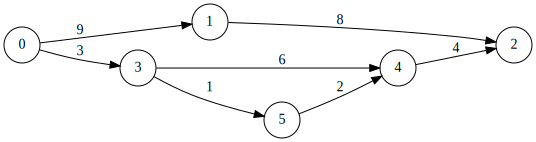

In [21]:
A = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 5],
    [1, 3, 2, 4, 5, 2, 4],
    [9, 3, 8, 6, 1, 4, 2],)

draw(A)

## Linear Algebra to solve Graph problems

The power of GraphBLAS is the use of Linear Algebra.  By relying on the mathmatical foundations of graph theory and abstract algebra, graph problems can be expressed in a closed, composible algebraic language.  Instead of thinking of problems node and edge at a time, GraphBLAS encourages you to think of and operate on the graph as a whole object using well understood mathmatical techniques.

## Adding Matrices

Adding two matrices with the plus operator (`+`) causes the two graphs to be combined together in a union of their nodes. This is the primary function of matrix addition, to union, or combine, two graphs.  The secondary purpose is to apply a combining function when both operands have an edge in common.  The default operator is the add the two weights, but there are many binary operators in GraphBLAS that can be used.

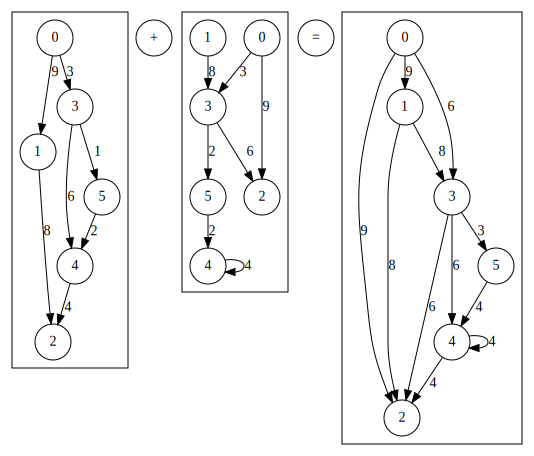

In [22]:
B = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 5],
    [2, 3, 3, 2, 5, 4, 4],
    [9, 3, 8, 6, 2, 4, 2],)

C = A + B
draw_op(A, '+', B, C)

## Using a different operator

To specify a different combining operator when elementwise addition, you can use the `with` syntax, inside this with block the specified operator is used.

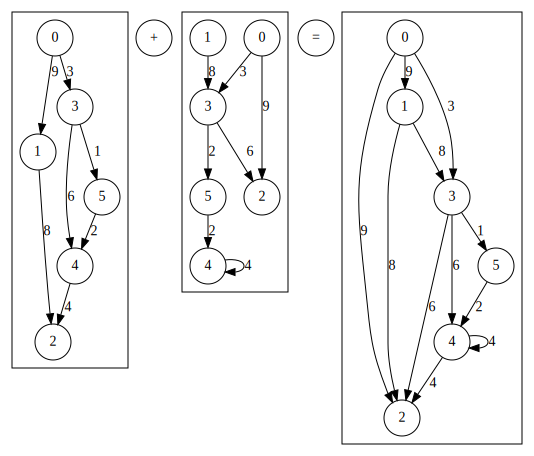

In [23]:
with min:
    C = A + B
draw_op(A, '+', B, C)

# Elementwise Multiplication

Multiplying two with the star operator (`*`) does elementwise multiplication, which returns only the intersection of nodes in the two graphs.  Note how this contrasts with elementwise addition above which takes the union.  Only the edges in common between the two graphs are operated on.  By default, those common nodes will have their weights multiplied.

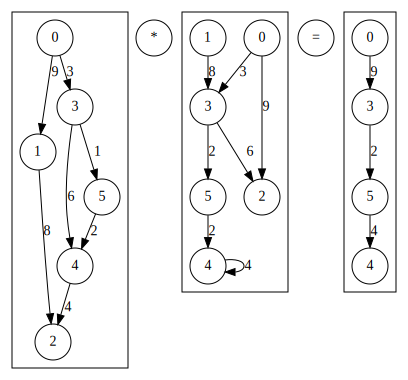

In [25]:
C = A * B
draw_op(A, '*', B, C)

# Elementwise Multiplication using different operators

Like addition, elementwise multiplication can use different operators:

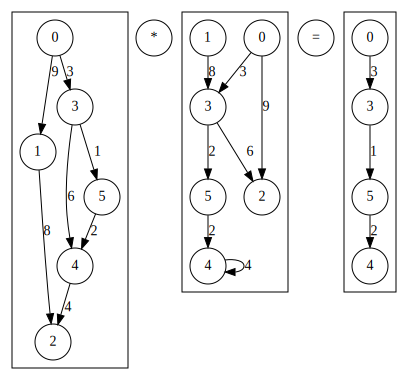

In [26]:
with min:
    C = A * B

draw_op(A, '*', B, C)

# Vector Matrix Multiplication

A Vector can be multiplied on the left by a matrix.  This is a fundamental "step" in a Breadth First Search (BFS) across the graph, the result are the adjacent edges to the input.  Note that the type of the result is that same as the left (vector) operand, in this case boolean:

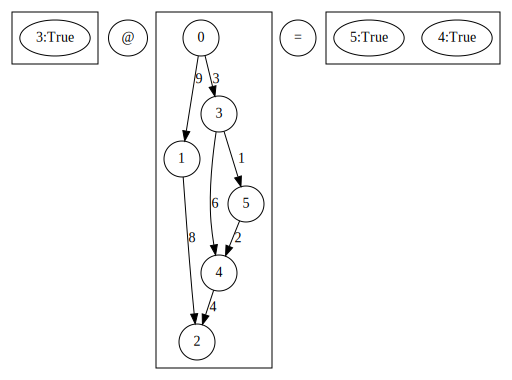

In [29]:
v = Vector.from_lists([3],[True], A.nrows)

y = v @ A
draw_op(v, '@', A, y)

## Matrix Vector multiplication

Matrices can be multiplied on the right by vectors, this is similar to taking a step "backwards" in a Breadth First Search, like above, but moving backwards along the edges.  Like above the output is the same as the left operand.

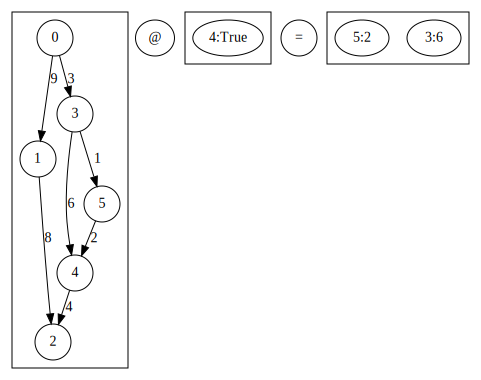

In [30]:
v = Vector.from_lists([4],[True], A.nrows)

draw_op(A, '@', v, A @ v)

# Row vs Column Vector Matrix Multiplication

`Av == vA'` so which direction to go depends on your style and problem.  But it's good to keep in mind these equivalents:

In [9]:
(A @ v == v @ A.transpose()).reduce_bool() and (v @ A == A.transpose() @ v).reduce_bool()

True

## Matrix Multiplication

The matrix multiplication operator (`@`) is also used to multiply two matrices.  The common data pattern is multiplying the rows of the left operand by the columns of the right operand and then summing the results.

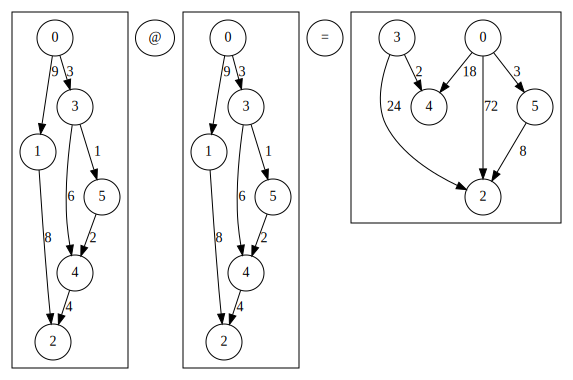

In [39]:
draw_op(A, '@', A, A @ A)

## Semirings

A different semiring can be used during matrix multiplication to get different results. A semiring defines two binary operators that are substituted for the multiplication "inner" matrix multiply operation and the addition "outer" operation.  In the next example uses the `min_plus` semiring.

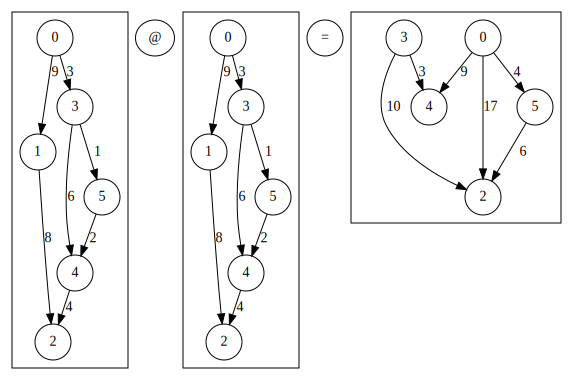

In [41]:
with min_plus:
    g = draw_op(A, '@', A, A @ A)
g

## Transpose

A matrix can be transposed with the `transpose()` method.  This effectively reverses the direction of edges in a graph.

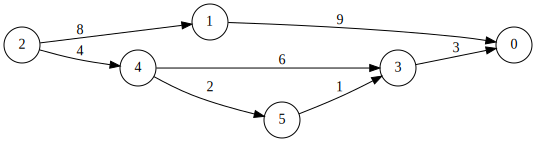

In [43]:
draw(A.transpose())

## Symmetric Graphs

Adding a graph to it's transpose makes its symmetric, every edge has a corresponding reverse edge.

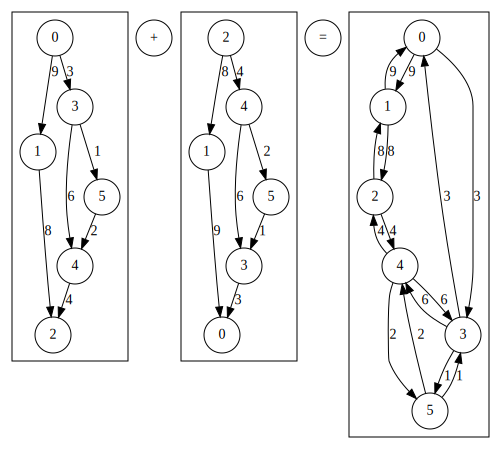

In [13]:
draw_op(A, '+', A.transpose(), A + A.transpose())

## Random Graphs

Random graphs can be constructed with the `from_random` Matrix class method.

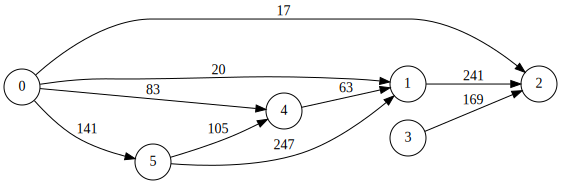

In [14]:
draw(Matrix.from_random(UINT8, 6,6,10, no_diagonal=True, seed=42), show_weight=True)

## Breadth First Search

Matrix multiplication is the basic operation for taking a step across a graph.  This single movement can be combined with a loop to step across an entire graph, tracking the distance from a beginning node to every other node in the graph.  This is called a *Breadth First Search*.

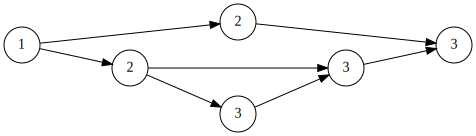

In [44]:

def bfs(matrix, start):
    """Given a graph and a starting position, return a vector of hops to all other nodes."""
    v = Vector.from_type(UINT8, matrix.nrows)   # the result vector
    q = Vector.from_type(BOOL, matrix.nrows)  # a vector to keep track of known nodes
    
    q[start] = True    # we know the distance to the start
    not_done = True
    level = 1
    
    while not_done and level <= matrix.nrows:
        v[:,q] = level                          # Assign the current level to known (q) nodes in v
        q = v.vxm(matrix, mask=v, desc=ooco)    # compliment the mask only find the next unknown nodes
        not_done = q.reduce_bool()              # is q full?
        level += 1                              # increment level
    return v
    
draw(A, show_weight=False, label_vector=bfs(A, 0))

## Shortest Path Length

Using the `min_plus` semiring a similar approach can be used to find the shortest path length between two nodes.  Note how instead of a mask/reduce operation, an equality comparison `iseq` is used to determine if a vector changes from one operation to the next.

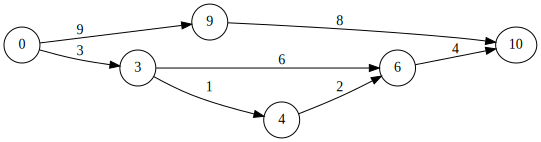

In [45]:
def shortest_path_length(matrix, start):
    v = Vector.from_type(matrix.type, matrix.nrows)
    v[start] = 0

    with min_plus, Accum(min):
        for _ in range(matrix.nrows):
            w = Vector.dup(v)
            v @= matrix
            if w.iseq(v):
                break
        return v

draw(A, label_vector=shortest_path_length(A, 0))